A notebook for finetuning Stable Diffusion using LORA.

Tested with [Stable Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5).

Notebook developed by [pedrogengo](https://github.com/pedrogengo).

# SETUP

In [4]:
!git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' lora/lora_diffusion/xformers_utils.py && sed -i 's/logging_dir=/project_dir=/g' lora/training_scripts/train_lora_dreambooth.py && pip install ./lora
!pip install accelerate bitsandbytes
!git clone https://github.com/fanis-khafizov/DreamBoothFineTune.git
# %load_ext tensorboard
# %tensorboard --logdir output/logs --port 6767

Cloning into 'lora'...
remote: Enumerating objects: 934, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 934 (delta 346), reused 301 (delta 301), pack-reused 527
Receiving objects: 100% (934/934), 182.96 MiB | 32.71 MiB/s, done.
Resolving deltas: 100% (560/560), done.
Processing ./lora
  Preparing metadata (setup.py) ... done
  Created wheel for lora-diffusion: filename=lora_diffusion-0.1.7-py3-none-any.whl size=38021 sha256=4a073551c49bd7fdf47a4d2f58097569fa1d93faccabd504961c66e67d270021
  Stored in directory: /tmp/pip-ephem-wheel-cache-vbo7t0t9/wheels/0c/9e/47/4f0b297b6d90f5353440a59949a797910cf16edd5cf0e5d990
Successfully built lora-diffusion
  Attempting uninstall: lora-diffusion
    Found existing installation: lora-diffusion 0.1.7
    Uninstalling lora-diffusion-0.1.7:
      Successfully uninstalled lora-diffusion-0.1.7
fatal: destination path 'DreamBoothFineTune' already exists and is not an empty directory.


# TRAINING

In [5]:
import os
import shutil
#from google.colab import files
from tqdm import tqdm

PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
PROMPT="A photo of a [V] cat" #@param{type: 'string'}
CLASS_PROMPT="A photo of a cat" #@param{type: 'string'}


OUTPUT_DIR="" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="DreamBoothFineTune/train_data/instance" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)

if PRETRAINED_MODEL == "":
  raise ValueError('[1;31mYou should define the pretrained model.')

INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL
CLASS_DIR = "DreamBoothFineTune/train_data/class"
if not os.path.exists(str(CLASS_DIR)):
     %mkdir -p "$INSTANCE_DIR"

if OUTPUT_DIR == "":
  OUTPUT_DIR = "output"
if not os.path.exists(str(OUTPUT_DIR)):
  %mkdir -p "$OUTPUT_DIR"

In [6]:
STEPS = 200 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 2 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}
LORA_RANK = 2 #@param {type:"slider", min:1, max:16, step:1}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 3e-4 #@param {type:"number"}

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 1e-5 #@param {type:"number"}

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

if TRAIN_TEXT_ENCODER:
    command = (f'python3 lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--class_data_dir="{CLASS_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--class_prompt="{CLASS_PROMPT}" '
             f'--resolution="{RESOLUTION}" '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size="{BATCH_SIZE}" '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank={LORA_RANK} '
             f'--with_prior_preservation '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER} '
             f'--num_class_images=40 '
             f'--seed=42 ')
else:
    command = (f'python3 lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--class_data_dir="{CLASS_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--class_prompt="{CLASS_PROMPT}" '
             f'--resolution="{RESOLUTION}" '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size="{BATCH_SIZE}" '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--lora_rank={LORA_RANK} '
             f'--with_prior_preservation '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER} '
             f'--num_class_images=40 '
             f'--seed=42 ')
!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# INFERENCE

In [7]:
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline

torch.manual_seed(42)

pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [8]:
pipe.safety_checker = None

  0%|          | 0/80 [00:00<?, ?it/s]

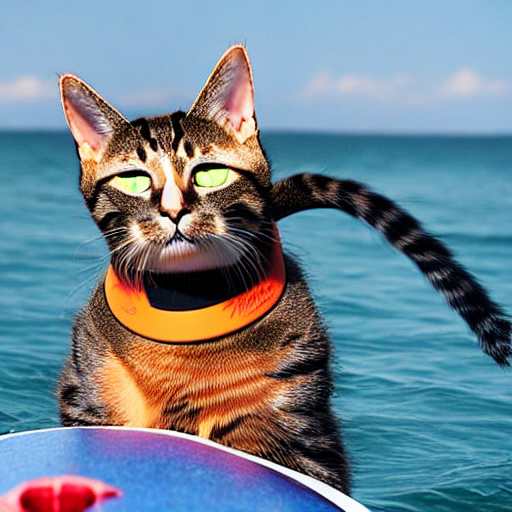

In [18]:
import random
INFERENCE_PROMPT = 'A photo of a cat on a paddleboard' #@param {type:"string"}
LORA_SCALE_UNET = 0.8 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1.0 #@param {type:"number"}
GUIDANCE = 7.6 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=80, guidance_scale=GUIDANCE).images[0]
image.save(f'{INFERENCE_PROMPT}-{str(random.randint(0, 10**9))}.jpg')
image